1. Import Libraries and Define Dataset Class

In [1]:
import os
import json
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

class JSONBasedBrainTumorDataset(Dataset):
    def __init__(self, json_path, images_dir, transform=None):
        with open(json_path, 'r') as file:
            self.data = json.load(file)
        self.images_dir = images_dir
        self.image_files = {img['id']: img['file_name'] for img in self.data['images']}
        self.annotations = {ann['image_id']: ann['category_id'] - 1 for ann in self.data['annotations']}  # Adjust labels
        self.transform = transform if transform else transforms.ToTensor()
        self.valid_image_ids = [img_id for img_id in self.image_files if img_id in self.annotations]

    def __len__(self):
        return len(self.valid_image_ids)

    def __getitem__(self, idx):
        image_id = self.valid_image_ids[idx]
        img_path = os.path.join(self.images_dir, self.image_files[image_id])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.annotations[image_id]
        return image, label

2. Setup Dataset Paths and Data Loaders

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.GaussianBlur(3),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_dir = "dataset"
train_dataset = JSONBasedBrainTumorDataset(
    json_path=os.path.join(dataset_dir, "train", "_annotations.coco.json"),
    images_dir=os.path.join(dataset_dir, "train"),
    transform=train_transforms
)
valid_dataset = JSONBasedBrainTumorDataset(
    json_path=os.path.join(dataset_dir, "valid", "_annotations.coco.json"),
    images_dir=os.path.join(dataset_dir, "valid"),
    transform=test_transforms
)
test_dataset = JSONBasedBrainTumorDataset(
    json_path=os.path.join(dataset_dir, "test", "_annotations.coco.json"),
    images_dir=os.path.join(dataset_dir, "test"),
    transform=test_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


3. Define Helper Functions for Metrics and Visualization

In [3]:
def plot_metrics(metrics, title):
    epochs = range(1, len(metrics["train_loss"]) + 1)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, metrics["train_loss"], label="Training Loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, metrics["val_accuracy"], label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, metrics["val_precision"], label="Validation Precision")
    plt.title("Validation Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs, metrics["val_recall"], label="Validation Recall")
    plt.title("Validation Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs, metrics["val_f1"], label="Validation F1-Score")
    plt.title("Validation F1-Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

4. Define Training Loop

In [4]:
def train_model(model, train_loader, valid_loader, optimizer, epochs):
    criterion = nn.CrossEntropyLoss()
    metrics = {"train_loss": [], "val_accuracy": [], "val_precision": [], "val_recall": [], "val_f1": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        metrics["train_loss"].append(train_loss)

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        metrics["val_accuracy"].append(accuracy)
        metrics["val_precision"].append(precision)
        metrics["val_recall"].append(recall)
        metrics["val_f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Accuracy: {accuracy:.4f}")

    return metrics

5. Train Baseline Model

Training Baseline Model...


Epoch 1/10: 100%|██████████| 47/47 [02:13<00:00,  2.83s/batch]


Epoch 1/10, Train Loss: 0.2631, Val Accuracy: 0.8951


Epoch 2/10: 100%|██████████| 47/47 [01:59<00:00,  2.54s/batch]


Epoch 2/10, Train Loss: 0.1498, Val Accuracy: 0.9604


Epoch 3/10: 100%|██████████| 47/47 [02:04<00:00,  2.65s/batch]


Epoch 3/10, Train Loss: 0.1297, Val Accuracy: 0.9744


Epoch 4/10: 100%|██████████| 47/47 [01:53<00:00,  2.42s/batch]


Epoch 4/10, Train Loss: 0.1150, Val Accuracy: 0.9860


Epoch 5/10: 100%|██████████| 47/47 [01:58<00:00,  2.52s/batch]


Epoch 5/10, Train Loss: 0.0972, Val Accuracy: 0.9837


Epoch 6/10: 100%|██████████| 47/47 [01:59<00:00,  2.54s/batch]


Epoch 6/10, Train Loss: 0.0853, Val Accuracy: 0.9744


Epoch 7/10: 100%|██████████| 47/47 [02:00<00:00,  2.57s/batch]


Epoch 7/10, Train Loss: 0.0803, Val Accuracy: 0.9930


Epoch 8/10: 100%|██████████| 47/47 [01:58<00:00,  2.52s/batch]


Epoch 8/10, Train Loss: 0.0656, Val Accuracy: 0.9837


Epoch 9/10: 100%|██████████| 47/47 [02:02<00:00,  2.60s/batch]


Epoch 9/10, Train Loss: 0.0692, Val Accuracy: 0.9720


Epoch 10/10: 100%|██████████| 47/47 [02:06<00:00,  2.69s/batch]


Epoch 10/10, Train Loss: 0.0700, Val Accuracy: 0.9860


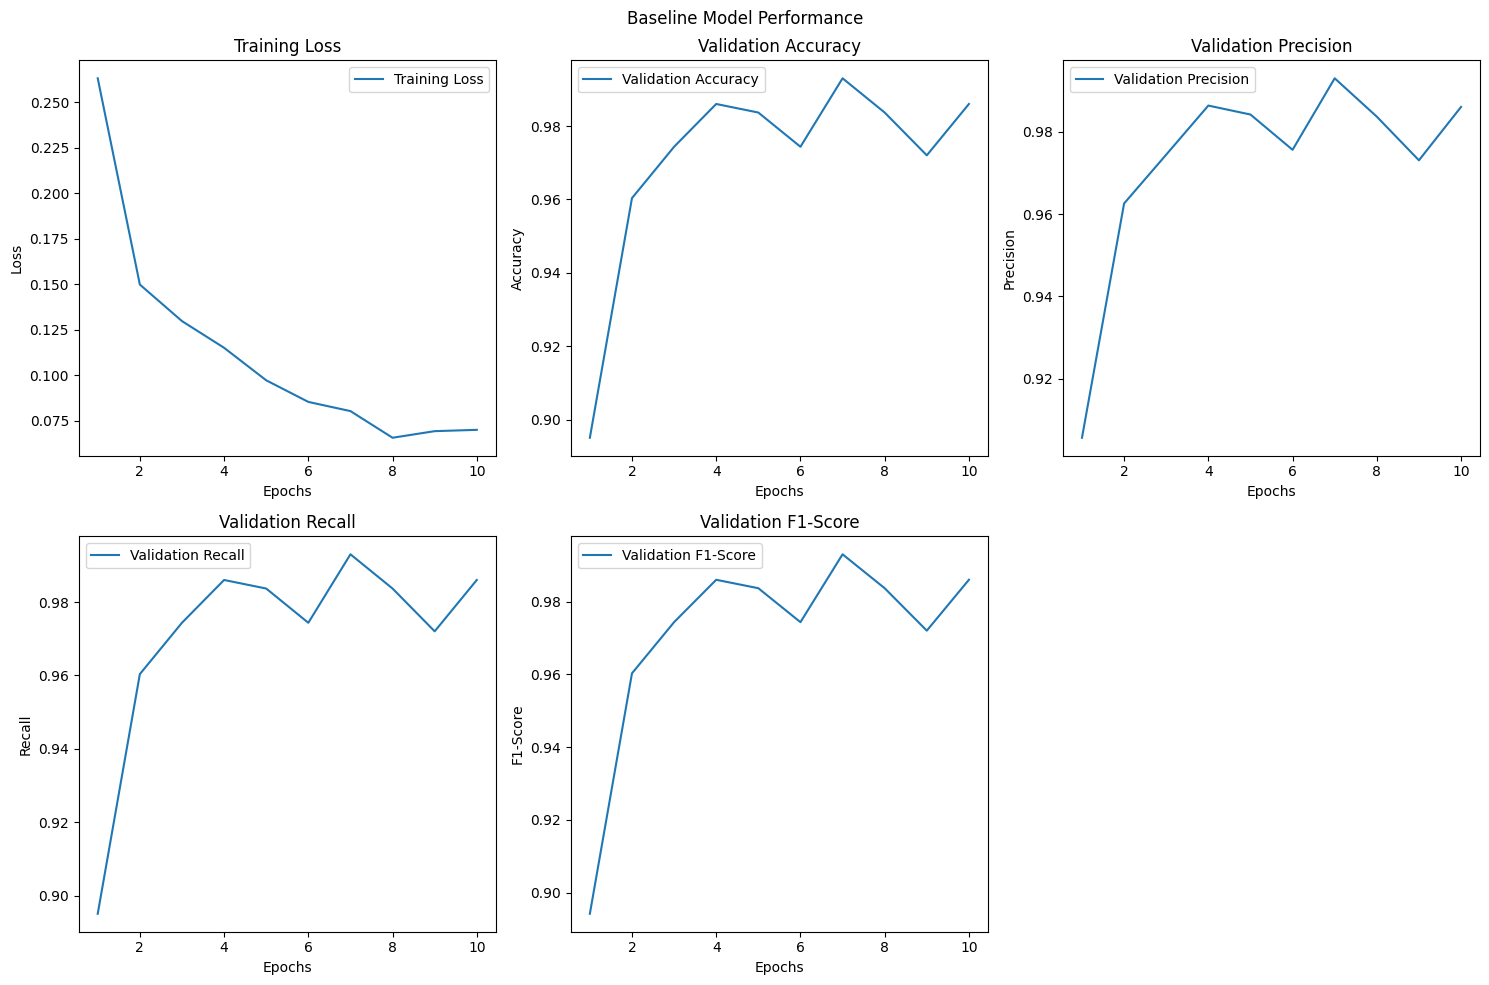

In [5]:
baseline_model = resnet18(weights=ResNet18_Weights.DEFAULT)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, 2)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.0001, weight_decay=1e-4)

print("Training Baseline Model...")
baseline_metrics = train_model(
    model=baseline_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=baseline_optimizer,
    epochs=10
)
plot_metrics(baseline_metrics, "Baseline Model Performance")

6. Train Enhanced Model

c:\Users\User\final project aml\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\final project aml\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training Enhanced Model


Epoch 1/10: 100%|██████████| 47/47 [02:05<00:00,  2.68s/batch]


Epoch 1/10, Train Loss: 0.3074, Val Accuracy: 0.9347


Epoch 2/10: 100%|██████████| 47/47 [02:03<00:00,  2.63s/batch]


Epoch 2/10, Train Loss: 0.1709, Val Accuracy: 0.9464


Epoch 3/10: 100%|██████████| 47/47 [02:10<00:00,  2.79s/batch]


Epoch 3/10, Train Loss: 0.1379, Val Accuracy: 0.9744


Epoch 4/10: 100%|██████████| 47/47 [02:14<00:00,  2.87s/batch]


Epoch 4/10, Train Loss: 0.1272, Val Accuracy: 0.9790


Epoch 5/10: 100%|██████████| 47/47 [02:07<00:00,  2.72s/batch]


Epoch 5/10, Train Loss: 0.1176, Val Accuracy: 0.9441


Epoch 6/10: 100%|██████████| 47/47 [02:14<00:00,  2.86s/batch]


Epoch 6/10, Train Loss: 0.1065, Val Accuracy: 0.9720


Epoch 7/10: 100%|██████████| 47/47 [02:08<00:00,  2.73s/batch]


Epoch 7/10, Train Loss: 0.0938, Val Accuracy: 0.9837


Epoch 8/10: 100%|██████████| 47/47 [02:01<00:00,  2.58s/batch]


Epoch 8/10, Train Loss: 0.0843, Val Accuracy: 0.9907


Epoch 9/10: 100%|██████████| 47/47 [02:06<00:00,  2.69s/batch]


Epoch 9/10, Train Loss: 0.0850, Val Accuracy: 0.9837


Epoch 10/10: 100%|██████████| 47/47 [02:12<00:00,  2.81s/batch]


Epoch 10/10, Train Loss: 0.0664, Val Accuracy: 0.9814


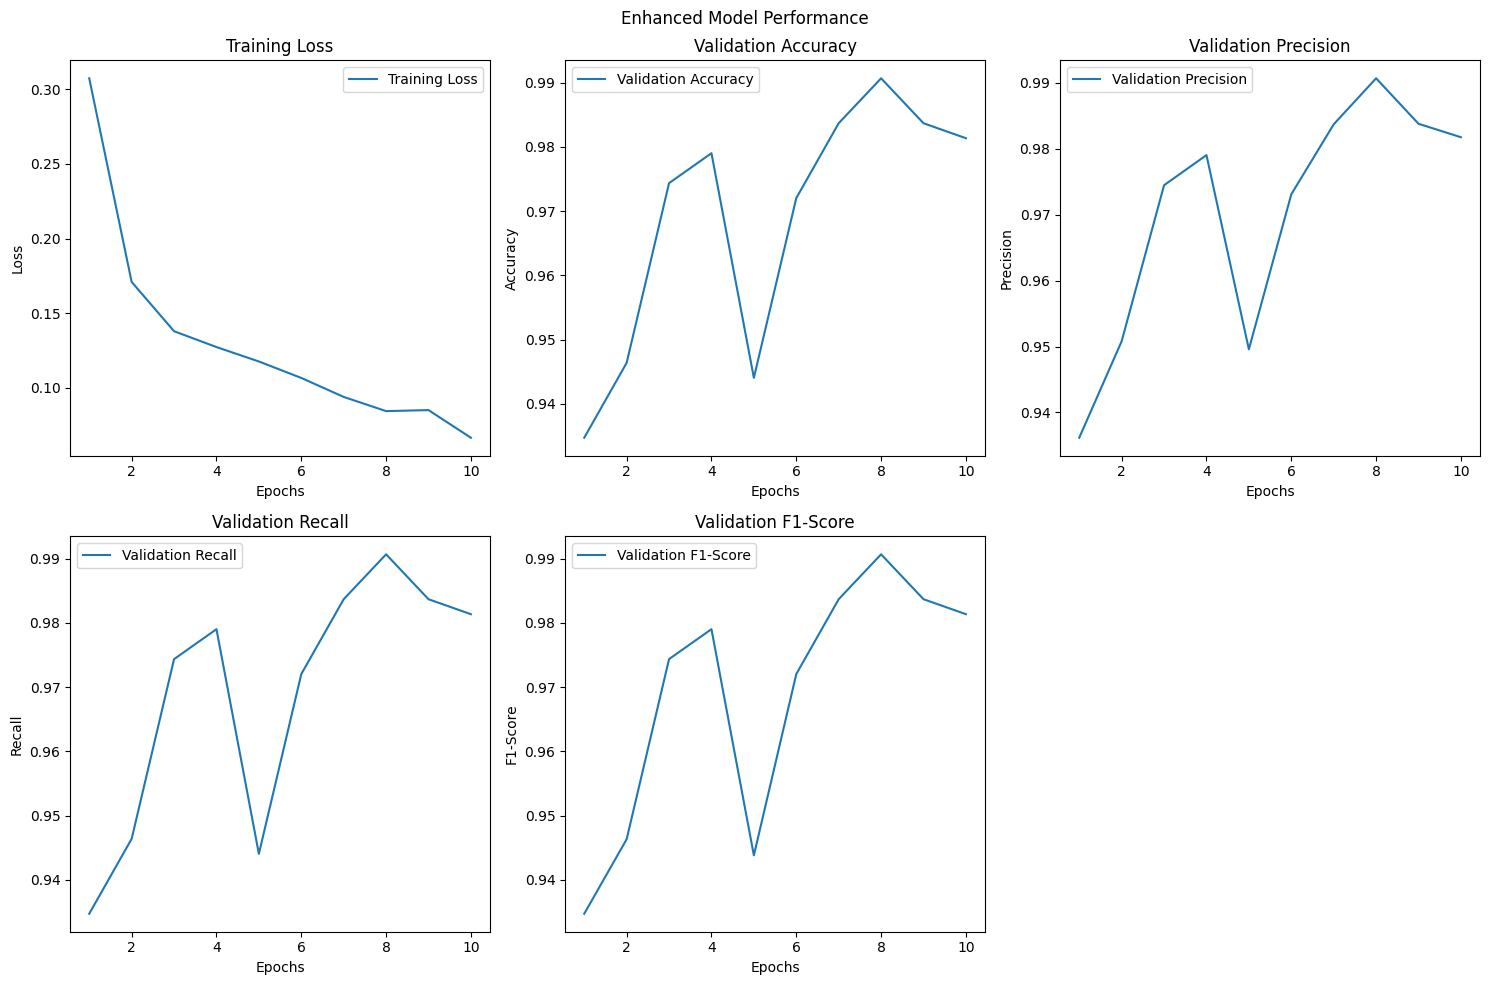

In [8]:
class EnhancedResNet18(nn.Module):
    def __init__(self):
        super(EnhancedResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.resnet(x)

enhanced_model = EnhancedResNet18()
enhanced_optimizer = optim.Adam(enhanced_model.parameters(), lr=0.0001, weight_decay=1e-4)

print("\nTraining Enhanced Model")
enhanced_metrics = train_model(enhanced_model, train_loader, valid_loader, enhanced_optimizer, epochs=10)
plot_metrics(enhanced_metrics, "Enhanced Model Performance")

7. Test Models on Test Set

In [9]:
def test_model(model, loader):
    print("\nTesting the Model")
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

print("\nBaseline Model Test Performance")
test_model(baseline_model, test_loader)

print("\nEnhanced Model Test Performance")
test_model(enhanced_model, test_loader)


Baseline Model Test Performance

Testing the Model
Test Accuracy: 0.9767, Precision: 0.9894, Recall: 0.9588, F1-Score: 0.9738

Enhanced Model Test Performance

Testing the Model
Test Accuracy: 0.9814, Precision: 0.9895, Recall: 0.9691, F1-Score: 0.9792
